# Example RMSD Analysis

This notebook is intended as a starting point for analysis of specific data. 

Here are some helpful resources (I (Caitlin) have not used all of them so feel free to add or remove anything that is(n't) useful.

### Pandas

Pandas is a very useful (and popular) python library for processing data. I like to think of it like an excell file, it is basically a matrix with labeled columns. That means you can access data based on a label instead of just an index as in a typical python list or array. 

* [Pandas documentation](http://pandas.pydata.org/pandas-docs/stable/)
* [10 minutes to pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html#min)
* [tutorials point](https://www.tutorialspoint.com/python_pandas/python_pandas_dataframe.htm)

##### LAMBDA Functions

Lambda is a key word in python that lets you build a "mini function." Here's [one tutorial](https://pythonconquerstheuniverse.wordpress.com/2011/08/29/lambda_tutorial/) and an example:

* Typical function definition:
```python
>>> def square_x(x): return x**2
>>> print(square_x(4))
16
```
* Using a lambda statement:
```python
>>> f = lambda x: x**2
>>> print(f(4))
16
```

In general these are not that common, but they are very useful with pandas as you can use `pandas.apply` to apply a lambda function to a whole column of the table

### Seaborn

Python's main plotting library is matplotlib. Seaborn is a library that takes advantage of matplotlib, but is generally a little easier to use and works well with pandas. 

* [Seaborn documentation](https://seaborn.pydata.org/)
* [Data Camp tutorial](https://www.datacamp.com/community/tutorials/seaborn-python-tutorial)

### Numpy

Initially this notebook isn't using Numpy directly, but it is an extremely useful library you should be aware of. It works mostly with a data structure called arrays which are a normal matrix. It allows you to do most mathematical opporations on those structures

* [introductory tutorial from numpy](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html)

### OEnotebook

OEnotebook is a useful jupyter notebook integration of the openeye tools for visualizing molecules, it interacts well with pandas as well. There are some great [examples online](http://notebooks.eyesopen.com/category/novice.html)

## Relevant conda/pip commands

If you are missing any of these packages they are all installable via conda or pip by the commands below. Openeye packages require a license. 

```
conda install pandas
conda install seaborn
conda install -c openeye openeye-toolkits
pip install --pre --extra-index-url https://pypi.anaconda.org/OpenEye/channel/beta/simple OpenEye-oenotebook
conda install mpld3
```
(mpld3 is used in some of the oenotebook plotting functions)

In [1]:
# helpful tools from openeye
import oenotebook as oenb
from openeye import oechem

import pandas as pd

import matplotlib
import seaborn as sns
import numpy as np
# Allows plots to show in notebook
% matplotlib inline

### Functions

In this section I've written a couple of helpful functions. 
I've tried to provide enough documentation for each. 

In [2]:
def smi_file_to_mol_dict(smi_file):
    """
    This method returns a dictionary of molecule in the input file

    Parameters
    -----------
    smi_file: This is a file storing molecules, probably a *.smi, but any molecule file should work
    
    Returns
    --------
    mol_dict: dictionary of the form {molname: OEMol}
    """
    mol_dict = dict()
    ifs = oechem.oemolistream(smi_file)
    mol = oechem.OEMol()
    while oechem.OEReadMolecule(ifs, mol):
        mol_dict[mol.GetTitle()] = oechem.OEMol(mol)
    ifs.close()
    return mol_dict
    

# Save data locations

In this example, we'll consider the two molecules used in the [examples on github](https://github.com/MobleyLab/off-ffcompare/tree/master/examples). 

First we will store the relevant data as global variables we can use throughout the notebook. 

In [3]:
SMI_FILE = './examples/example_molecules.smi'
MOL_DICT = smi_file_to_mol_dict(SMI_FILE)
RMSD_FILE = './examples/RMSD.txt'

## Make Pandas of RMSD Data

In this section we will do the following steps:

1. Read in a `README.txt` file into a pandas DataFrame
2. Add a Molecules column to the dataframe and visualize the columns with oenotebook
    - 2.5 - add additional columns to the dataframe
3. Use Seaborn to make a histogram plot 
4. Use OENotebook to make a plot comparing RMSDs with molecule visualizations

In [4]:
# 1. Read in a README.txt file into a pandas DataFrame
# ----------------------------------------------------------
# create dataframe 
df = pd.read_csv(RMSD_FILE, sep='\t', comment='#')


# the column labels in this case have some weird spaces, we can fix this with 
# the pandas function rename, first we'll show the columns
print(df.columns)
# then make a dictionary of the "stripped" column lables
strip_columns = {c:c.strip() for c in df.columns} 
df.rename(columns=strip_columns, inplace=True) # if inplace = False this returns a new df instead
# show the new column titles
print(df.columns)

# We'll do the same thing for the strings in the MolName column
strip_names = {m:m.strip() for m in df.MolName.values}
df.replace(strip_names, inplace=True)

# If you end a jupyter cell with it you can see the dataframe
df

Index(['  MolName           ', 'SMIRNOFF ', 'GAFF     ', 'GAFF2    ',
       'MMFF94   ', 'MMFF94S  ', 'OPLS2005 ', 'OPLS3    '],
      dtype='object')
Index(['MolName', 'SMIRNOFF', 'GAFF', 'GAFF2', 'MMFF94', 'MMFF94S', 'OPLS2005',
       'OPLS3'],
      dtype='object')


,MolName,SMIRNOFF,GAFF,GAFF2,MMFF94,MMFF94S,OPLS2005,OPLS3
0,AlkEthOH_c42,0.0,0.02525,0.04161,0.02616,0.02616,0.08488,0.02902
1,AlkEthOH_c80,0.0,0.03923,0.06863,0.03149,0.03149,0.05805,0.03547


,MolName,SMIRNOFF,GAFF,GAFF2,MMFF94,MMFF94S,OPLS2005,OPLS3,mols
0,AlkEthOH_c42,0.0,0.02525,0.04161,0.02616,0.02616,0.08488,0.02902,
1,AlkEthOH_c80,0.0,0.03923,0.06863,0.03149,0.03149,0.05805,0.03547,

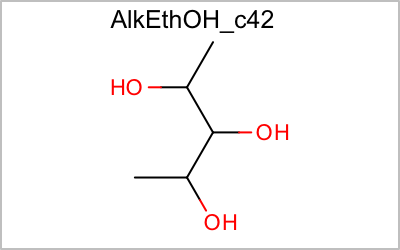
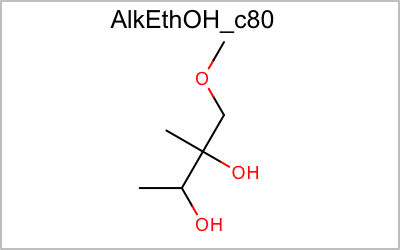

In [5]:
# 2. Add a Molecules column to the dataframe and visualize the columns with oenotebook
# -------------------------------------------------------------------------------------
# add a colum to the pandas dataframe for the molecules object. 
# We do this by declaring the name of the new column and using the apply function 
#     to apply the command to all entries in a given column
df['mols'] = df.MolName.apply(lambda x: MOL_DICT[x])

# oenotebook lets you visualize molecules in a database
# be aware that you probably don't want to do this with a LARGE dataframe 
# or you'll run out of memory in the notebook so you might want to slice the dataframe before this in the future
oenb.render_dataframe(df, mol_col='mols') # default for mol_col is 'Molecule'

,mols,rotatable,heavy,GAFF
0,,2,8,0.02525
1,,3,9,0.03923

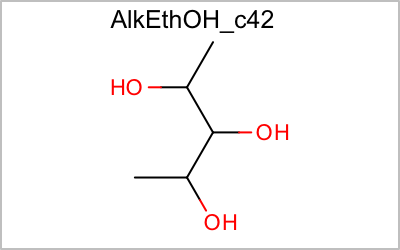
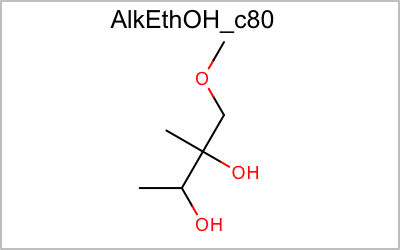

In [7]:
# 2.5 - add additional columns to the dataframe
# --------------------------------------------------
# We can add more colums to the dataframe using functions from the oechem toolkit
# If there is something you want to know about the molecule, oechem can probably calculate it
df['MW'] = df.mols.apply(oechem.OECalculateMolecularWeight)
df['heavy'] = df.mols.apply(lambda x: oechem.OECount(x, oechem.OEIsHeavy()))
df['rotatable'] = df.mols.apply(lambda x: oechem.OECount(x, oechem.OEIsRotor()))

# You can view a subset of the data in the oenotebook visualization if you want, 
# by specifying a list of columns
view_cols = ['mols', 'rotatable', 'heavy', 'GAFF']
oenb.render_dataframe(df[view_cols], mol_col='mols')

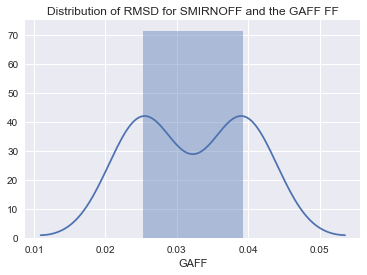

In [8]:
# 3. Use Seaborn to make a histogram plot
# ---------------------------------------------
# pick a forcefield:
FF = 'GAFF'
# make the plot
f = sns.plt.figure()
ax = sns.distplot(df[FF])
ax.set_title("Distribution of RMSD for SMIRNOFF and the %s FF" % FF)
# If you want to save the figure use:
# f.savefig('/path/to/plot_file.png')
# this should support most image file formats (pdf, png, jpeg?)

Note this figure doesn't make much sense since it only has two datapoints


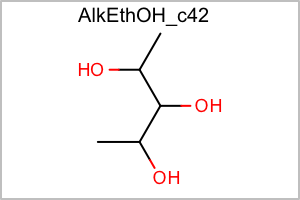
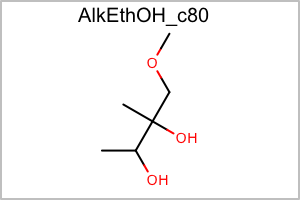
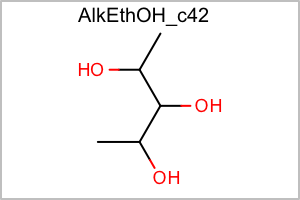
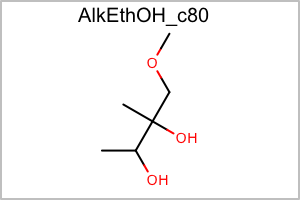
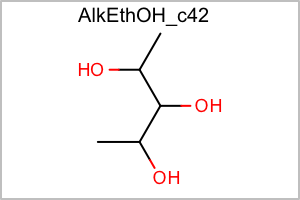
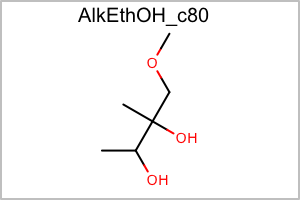

(<matplotlib.figure.Figure at 0x11c1fe748>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1206fa0f0>)

In [10]:
# 4. Use OENotebook to make a plot comparing RMSDs with molecule visualizations
# ---------------------------------------------------------------------------------
# OENotebook has a handy plotting function where you can scroll over the points and see the molecule
# I'm going to use an example where we might want to see if the RMSD is related or scales by the number
# of rotatable bonds in the molecule

oenb.scatter_mpl(df, 'GAFF', 'rotatable', mol_col='mols')

# note there are only two points here so not enough to draw any conclusions

## Make sub-dataframes

There are lots of ways to "crop" the pandas dataframes 
by data, you can use column selection, apply statements, and other pandas functions.
Below are a few examples of how to do this, but check out the pandas
tutorials to see other options. 

One thing to understand in this section, is essentially you look for things where a certain value is `True`.
This happens in the form
```python
sub_df = df[df.column_name.pd_function(...)]
```
where if you only used the `df.column_name.pd_function(...)` part you would make a column of 
`True` or `False` values. the `df[...]` part says I only want the part of df where the inside is `True`. 

,mols,rotatable,heavy,GAFF
1,,3,9,0.03923

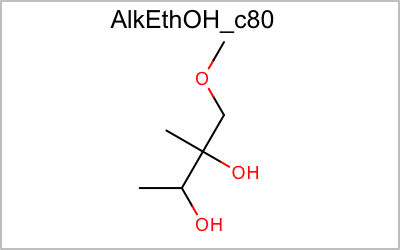

In [14]:
# first, lets look for things where there are specific values
# In this example we'll make a sub dataframe with only molecules with 3 rotatable bonds:
sub1 = df[df.rotatable.isin([3])].copy()
view_cols = ['mols', 'rotatable', 'heavy', 'GAFF']
oenb.render_dataframe(sub1[view_cols], mol_col='mols')

,MolName,mols,MW,rotatable,GAFF,MMFF94S
0,AlkEthOH_c42,,120.14698,2,0.02525,0.02616
1,AlkEthOH_c80,,134.17356,3,0.03923,0.03149

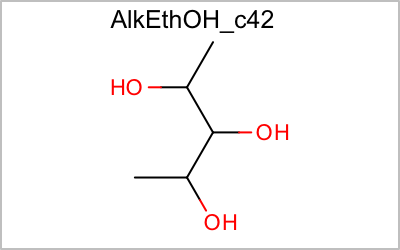
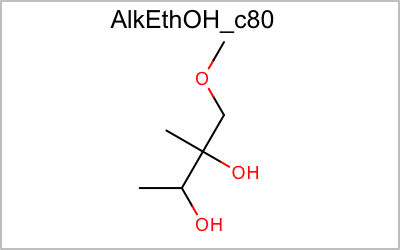

In [16]:
# Maybe you only want a subset of columns
# Make sure to always copy it
sub2 = df[['MolName', 'mols', 'MW', 'rotatable', 'GAFF', 'MMFF94S']].copy() 
oenb.render_dataframe(sub2, mol_col='mols')

,MolName,SMIRNOFF,GAFF,GAFF2,MMFF94,MMFF94S,OPLS2005,OPLS3,mols,MW,heavy,rotatable
0,AlkEthOH_c42,0.0,0.02525,0.04161,0.02616,0.02616,0.08488,0.02902,,120.14698,8,2

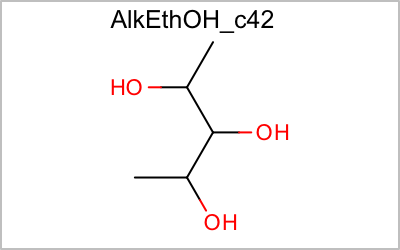

In [19]:
# Maybe you want to isolate molecules with an RMSD in a certain range for a certain force field
# we could write a way to do this for ALL FF, but it would be more complicated. 
sub3 = df[df.MMFF94S.apply(lambda x: x < 0.03)].copy()
oenb.render_dataframe(sub3, mol_col='mols')

## Use Help functions

This is a reminder that the point of documentation on python functions is that you can use the python 
help function to learn how to use it. Below is an example showing how to use the `read_csv` function for pandas.

In [11]:
help(pd.read_csv)

Help on function read_csv in module pandas.io.parsers:

read_csv(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', quoting=0, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=False, error_bad_lines=True, warn_bad_lines=True, skipfooter=0, skip_footer=0, doublequote=True, delim_whitespace=False, as_recarray=False, compact_ints=False, use_unsigned=False, low_memory=True, buffer_lines=None, memory_map=False, float_precision=No